# DLAV Project - Phase 3

In this notebook we will train a very simple planner and test its real-world performance.


The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [ ]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = "dlav_val_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5"
output_zip = "test_public_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=8ddbd207-f6e5-440f-9d69-a0350c56cda1
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:04<00:00, 99.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if
From (redirected): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if&confirm=t&uuid=11b3fbd7-6dcf-491e-9fe1-1d9ac1ad7268
To: /content/dlav_val_real.zip
100%|██████████| 129M/129M [00:01<00:00, 74.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5
From (redirected): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5&confirm=t&uuid=3bf8c7f1-46a1-46e9-a866-7bc9935ddd3a
To: /content/test_public_real.zip
100%|██████████| 110M/110M [00:00<00:00, 183MB/s]


Now lets load the data and visualize how the real data looks like!

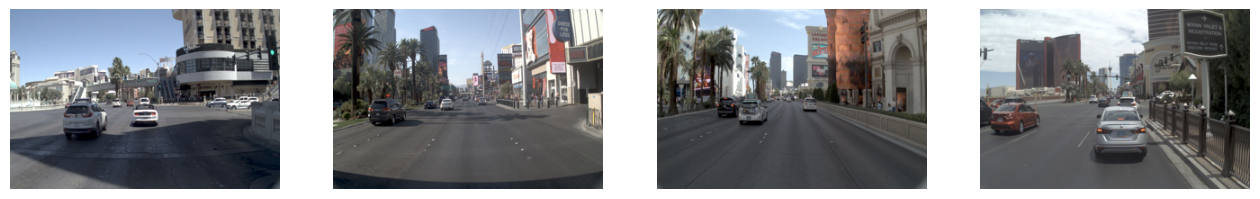

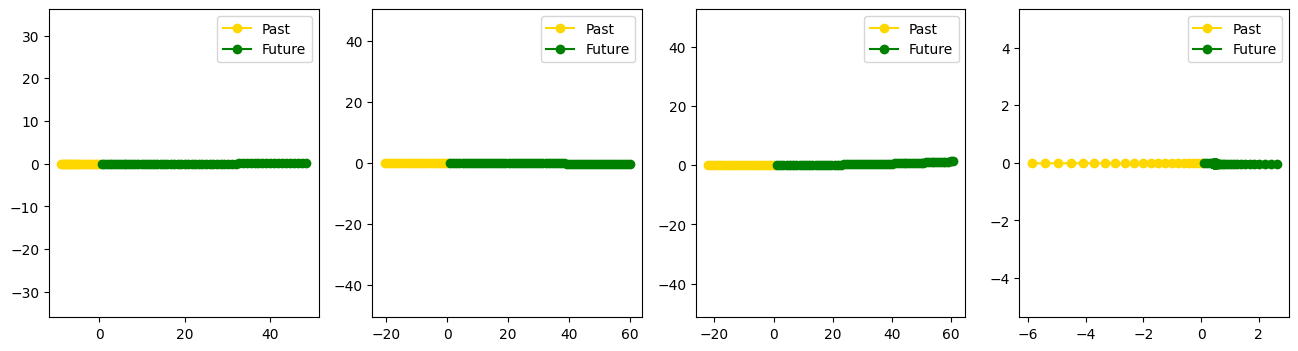

In [ ]:

import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import os
k = 4
# load the data
data = []
test_files = os.listdir("val_real")

for i in range(k):
    with open(f"val_real/{test_files[i]}", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now let's train the model with synthetic data and test it with the real-world data.

In [ ]:
#install ultralytics for YOLO segmentation
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.4 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import torch
from torch.utils.data import Dataset
from ultralytics import YOLO
import torch.nn.functional as F


class DrivingDataset(Dataset):

    # relevant coco ids for driving, cars, trucks etc.
    RELEVANT_CLASSES = [2, 3, 5, 6, 7, 9, 11]

    def __init__(
        self,
        file_list: list[str],
        #pull default YOLO v11 segmentation model
        yolo_weights: str = "yolo11n-seg.pt",
        device: str | torch.device = "cuda" if torch.cuda.is_available() else "cpu",
        test: bool = False,
    ):
        self.samples = file_list
        self.test    = test
        self.device  = torch.device(device)

        # one YOLO model per dataset worker
        self.yolo = YOLO(yolo_weights).to(self.device).eval()

        # map ids to channel index inside the tensor
        self.class_to_channel = {
            cid: ch for ch, cid in enumerate(self.RELEVANT_CLASSES)
        }
        self.num_channels = len(self.RELEVANT_CLASSES)

    def __len__(self):
        return len(self.samples)

    @torch.no_grad()
    def _yolo_masks(self, img_np):
        """
        Run YOLO-Seg and return a (C, H, W) float tensor, where
        C = len(RELEVANT_CLASSES). Each channel is a binary mask.
        """
        H, W, _ = img_np.shape
        # run the model (retina_masks=True resizes masks to H×W)
        res = self.yolo(img_np, device=self.device, retina_masks=True, verbose=False)[0]

        # start with an all-zero tensor
        masks = torch.zeros(
            (self.num_channels, H, W),
            dtype=torch.float32,
            device=self.device
        )

        if res.masks is None or res.masks.data.numel() == 0:
            return masks                     # nothing detected

        for m, cls_id in zip(res.masks.data, res.boxes.cls.int()):
            cid = int(cls_id)
            ch  = self.class_to_channel.get(cid, None)
            if ch is not None:               # only keep relevant classes
                # -------- changed line --------
                masks[ch] = torch.maximum(masks[ch], m.float())
                # --------------------------------

        return masks


    def __getitem__(self, idx):
        # ── load pickle ───────────────────────────────────────────────
        with open(self.samples[idx], "rb") as f:
            data = pickle.load(f)

        # ── camera image ──────────────────────────────────────────────
        camera_np = data["camera"]                       # keep in numpy for YOLO
        camera_t  = torch.as_tensor(camera_np).permute(2, 0, 1).float()

        # ── YOLO class-separated masks ───────────────────────────────
        masks_t   = self._yolo_masks(camera_np)          # [C,H,W] float32 0/1

        # ── other tensors ────────────────────────────────────────────
        history_t = torch.as_tensor(data["sdc_history_feature"]).float()

        sample = {
            "camera": camera_t,
            "history": history_t,
            "masks": masks_t, #added YOLO masks
        }

        if not self.test:
            future_t         = torch.as_tensor(data["sdc_future_feature"]).float()
            sample["future"] = future_t

        return sample


In [ ]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

Note: Replace with your own planner below

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class DrivingPlanner(nn.Module):
    """
    camera (RGB)  → visual CNN  → 256-d
    masks  (C)    → mask  CNN   →  64-d
    history (T×3) → MLP         → 256-d
                                 ─────────
                      concat     → 576-d
                      decoder    → 60×3 future trajectory
    """

    def __init__(self, num_mask_channels: int = 7):
        super().__init__()

        # CNN for RGB camera frames (unchanged)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()                    # → 256
        )

        # ⚡ CNN for per-class masks  (much lighter)
        self.mask_cnn = nn.Sequential(
            nn.Conv2d(num_mask_channels, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()                    # → 64
        )

        # MLP for history (unchanged)
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()                       # → 256
        )

        # ⚡ Decoder input size is now 256+64+256 = 576
        self.decoder = nn.Sequential(
            nn.Linear(576, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 60 * 3)          # 60 timesteps × (x,y,heading)
        )

    def forward(self, camera, masks, history):
        # camera:  (B, 3,   H, W)
        # masks :  (B, C,   H, W)   C = num_mask_channels
        # history: (B, 21, 3)

        visual_feat = self.cnn(camera)                 # (B, 256)
        mask_feat   = self.mask_cnn(masks)             # (B,  64)

        history_flat = history.reshape(history.size(0), -1)
        history_feat = self.history_encoder(history_flat)  # (B, 256)

        combined = torch.cat([visual_feat, mask_feat, history_feat], dim=1)
        future   = self.decoder(combined).reshape(-1, 60, 3)

        return future

In [ ]:
def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = model.to(device)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for idx, batch in enumerate(train_loader):
            camera  = batch['camera'].to(device)
            masks   = batch['masks'].to(device)
            history = batch['history'].to(device)
            future  = batch['future'].to(device)

            optimizer.zero_grad()
            pred_future = model(camera, masks, history)
            loss = criterion(pred_future[..., :2], future[..., :2])
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        # ── VALIDATE ────────────────────────────────────────────
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera  = batch['camera'].to(device)
                masks   = batch['masks'].to(device)
                history = batch['history'].to(device)
                future  = batch['future'].to(device)

                pred_future = model(camera, masks, history)
                loss = criterion(pred_future, future)
                ADE  = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE  = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()

                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss/len(train_loader):.4f} | '
              f'Val Loss: {val_loss/len(val_loader):.4f} | '
              f'ADE: {np.mean(ade_all):.4f} | '
              f'FDE: {np.mean(fde_all):.4f}')

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
real_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]

train_files_mixed = train_files + test_files[:500]
test_files = test_files[500:]

train_dataset = DrivingDataset(train_files_mixed)
val_dataset = DrivingDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=0)

model = DrivingPlanner()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

logger = Logger()

train(model, train_loader, val_loader, optimizer, logger, num_epochs=50)

Epoch 1/50 | Train Loss: 28.8604 | Val Loss: 18.4822 | ADE: 3.1807 | FDE: 8.0275
Epoch 2/50 | Train Loss: 12.1112 | Val Loss: 12.1283 | ADE: 2.4203 | FDE: 6.2511
Epoch 3/50 | Train Loss: 9.8969 | Val Loss: 10.9860 | ADE: 2.3416 | FDE: 6.5563
Epoch 4/50 | Train Loss: 9.4779 | Val Loss: 10.3975 | ADE: 2.2796 | FDE: 6.1794
Epoch 5/50 | Train Loss: 8.9862 | Val Loss: 10.2104 | ADE: 2.1467 | FDE: 5.9155
Epoch 6/50 | Train Loss: 8.8813 | Val Loss: 9.5973 | ADE: 2.3493 | FDE: 6.2950
Epoch 7/50 | Train Loss: 8.3783 | Val Loss: 9.4728 | ADE: 2.2048 | FDE: 6.0731
Epoch 8/50 | Train Loss: 8.6543 | Val Loss: 8.9677 | ADE: 2.2289 | FDE: 5.9667
Epoch 9/50 | Train Loss: 7.6657 | Val Loss: 8.5144 | ADE: 2.0465 | FDE: 5.5767
Epoch 10/50 | Train Loss: 7.8031 | Val Loss: 8.4975 | ADE: 2.1021 | FDE: 5.8035
Epoch 11/50 | Train Loss: 7.2222 | Val Loss: 8.3480 | ADE: 2.1908 | FDE: 6.1695
Epoch 12/50 | Train Loss: 6.7538 | Val Loss: 8.7347 | ADE: 2.3080 | FDE: 6.3169
Epoch 13/50 | Train Loss: 6.6483 | Val Los

Finally, generate your submission.

In [ ]:
# ─────────────── inference on the public-test set (safe for CUDA) ───────────────
import os, torch, numpy as np, pandas as pd
from torch.utils.data import DataLoader

test_files = sorted(
    [os.path.join("test_public_real", f)
     for f in os.listdir("test_public_real") if f.endswith(".pkl")],
    key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
)

test_dataset = DrivingDataset(test_files, test=True)      # provides .masks
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    num_workers=0,          # keep workers in the main proc
    pin_memory=False        #  ← turn it off
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

preds = []
with torch.no_grad():
    for batch in test_loader:
        cams   = batch["camera"].to(device, non_blocking=True)
        masks  = batch["masks"].to(device,  non_blocking=True)
        hist   = batch["history"].to(device, non_blocking=True)

        fut = model(cams, masks, hist)[:, :, :2]          # (B,60,2)
        preds.append(fut.cpu().numpy())

pred_xy = np.concatenate(preds)                          # (N,60,2)
N, T, _ = pred_xy.shape
df = pd.DataFrame(pred_xy.reshape(N, T*2),
                  columns=[f"{ax}_{t+1}" for t in range(T) for ax in ("x","y")])
df.insert(0, "id", np.arange(N))
df.to_csv("submission_phase3.csv", index=False)
print("Saved submission_phase3.csv  ➜  shape", df.shape)


Saved submission_phase3.csv  ➜  shape (864, 121)
